<a href="https://colab.research.google.com/github/aditya26091999/music-genre-classification/blob/main/music_genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
#Downloading some Google-Collab exclusive dependencies
!pip install flask-ngrok

# Importing the necessary libraries for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh as bk
import plotly as p
from flask_ngrok import run_with_ngrok
from flask import Flask,jsonify,request
from IPython.display import display
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.metrics import classification_report,plot_confusion_matrix

import pickle

# Loading Dataset and basic EDA


Getting dataset from Github

In [ ]:
#loading the dataset from Github folder
datasetUrl = 'https://raw.githubusercontent.com/aditya26091999/music-genre-classification/main/Probable%20Datasets/26-Genres.csv'
dataset = pd.read_csv(datasetUrl)

#checking the dataset loaded from Github
display(dataset.head())

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


EDA on RAW dataset


In [ ]:
dataset.shape

(232725, 18)

In [ ]:
dataset.columns

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

In [ ]:
dataset.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
genre,232725,27,Comedy,9681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist_name,232725,14564,Giuseppe Verdi,1394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
track_name,232725,148615,Home,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
track_id,232725,176774,3uSSjnDMmoyERaAK9KvpJR,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
popularity,232725,NaN,NaN,NaN,41.1275,18.1899,0,29,43,55,100
acousticness,232725,NaN,NaN,NaN,0.36856,0.354768,0,0.0376,0.232,0.722,0.996
danceability,232725,NaN,NaN,NaN,0.554364,0.185608,0.0569,0.435,0.571,0.692,0.989
duration_ms,232725,NaN,NaN,NaN,235122,118936,15387,182857,220427,265768,5.55292e+06
energy,232725,NaN,NaN,NaN,0.570958,0.263456,2.03e-05,0.385,0.605,0.787,0.999
instrumentalness,232725,NaN,NaN,NaN,0.148301,0.302768,0,0,4.43e-05,0.0358,0.999


Observed Duplicates in the dataset

In [ ]:
#Same songs belonging to the different genres -> might create problem while training
df = dataset[dataset['track_id']=='0wY9rA9fJkuESyYm9uzVK5']
display(df)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
1804,Alternative,SiR,D'Evils,0wY9rA9fJkuESyYm9uzVK5,63,0.00558,0.784,171818,0.586,0.000286,C#,0.106,-3.417,Major,0.187,132.169,4/4,0.656
68204,Hip-Hop,SiR,D'Evils,0wY9rA9fJkuESyYm9uzVK5,67,0.00558,0.784,171818,0.586,0.000286,C#,0.106,-3.417,Major,0.187,132.169,4/4,0.656
77892,Children’s Music,SiR,D'Evils,0wY9rA9fJkuESyYm9uzVK5,66,0.00558,0.784,171818,0.586,0.000286,C#,0.106,-3.417,Major,0.187,132.169,4/4,0.656
93893,Indie,SiR,D'Evils,0wY9rA9fJkuESyYm9uzVK5,67,0.00558,0.784,171818,0.586,0.000286,C#,0.106,-3.417,Major,0.187,132.169,4/4,0.656
115551,Rap,SiR,D'Evils,0wY9rA9fJkuESyYm9uzVK5,67,0.00558,0.784,171818,0.586,0.000286,C#,0.106,-3.417,Major,0.187,132.169,4/4,0.656
149893,Pop,SiR,D'Evils,0wY9rA9fJkuESyYm9uzVK5,67,0.00558,0.784,171818,0.586,0.000286,C#,0.106,-3.417,Major,0.187,132.169,4/4,0.656
152677,R&B,SiR,D'Evils,0wY9rA9fJkuESyYm9uzVK5,67,0.00558,0.784,171818,0.586,0.000286,C#,0.106,-3.417,Major,0.187,132.169,4/4,0.656
192273,Soul,SiR,D'Evils,0wY9rA9fJkuESyYm9uzVK5,67,0.00558,0.784,171818,0.586,0.000286,C#,0.106,-3.417,Major,0.187,132.169,4/4,0.656


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

Exploring Categorical variables

In [ ]:
dataset.genre.unique()

array(['Movie', 'R&B', 'A Capella', 'Alternative', 'Country', 'Dance',
       'Electronic', 'Anime', 'Folk', 'Blues', 'Opera', 'Hip-Hop',
       "Children's Music", 'Children’s Music', 'Rap', 'Indie',
       'Classical', 'Pop', 'Reggae', 'Reggaeton', 'Jazz', 'Rock', 'Ska',
       'Comedy', 'Soul', 'Soundtrack', 'World'], dtype=object)

In [ ]:
dataset.popularity.unique()

array([  0,   1,   3,   4,   2,  15,  10,   8,   5,   6,   7,  11,  65,
        63,  62,  61,  68,  64,  66,  60,  69,  71,  76,  67,  70,  72,
        57,  59,  56,  28,  31,  74,  55,  53,   9,  13,  23,  12,  44,
        33,  25,  26,  24,  22,  20,  19,  18,  16,  17,  14,  83,  81,
        73,  78,  77,  75,  45,  42,  46,  54,  41,  52,  58,  51,  43,
        47,  48,  40,  50,  49,  39,  80,  37,  35,  21,  38,  36,  29,
        34,  32,  99, 100,  97,  92,  91,  95,  90,  93,  88,  87,  89,
        96,  86,  85,  84,  94,  82,  79,  27,  30,  98])

In [ ]:
# Had to use square brackets beacause python has mode-keyword
dataset['mode'].unique()

array(['Major', 'Minor'], dtype=object)

In [ ]:
dataset.time_signature.unique()

array(['4/4', '5/4', '3/4', '1/4', '0/4'], dtype=object)

Checking for null values

In [ ]:
dataset.isnull().sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

# Cleaning the dataset

In [ ]:
print("Raw dataset shape",dataset.shape)

#Cleanning the dataset for unwanted rows and columns
columns_to_drop = ['artist_name', 'track_name']

# rows_to_drop = ['Movie', 'R&B', 'A Capella', 'Alternative', 'Anime','Blues', 'Opera',"Children's Music", 'Children’s Music', 'Indie', 'Reggae', 'Reggaeton', 'Ska', 'Comedy', 'Soul','Soundtrack', 'World']

rows_to_drop = ['Movie', 'R&B', 'A Capella', 'Alternative', 'Country', 'Dance',
        'Anime', 'Folk', 'Blues', 'Opera',
       "Children's Music", 'Children’s Music', 'Rap', 'Indie',
        'Reggae', 'Reggaeton', 'Rock', 'Ska',
       'Comedy', 'Soul', 'Soundtrack', 'World']

# Dropping the unwanted features(columns)
dataset.drop(columns_to_drop,axis=1,inplace=True)

# Dropping the unwanted classes(rows)
for x in rows_to_drop:
  dataset.drop(dataset.loc[dataset['genre'] == x].index,inplace=True)

print("Partially cleaned dataset shape",dataset.shape)

Raw dataset shape (232725, 18)
Partially cleaned dataset shape (46755, 16)


Working on the duplicates

In [ ]:
dataset = dataset.sort_values(by=['popularity'])
dataset = dataset.drop_duplicates(subset=['track_id'],keep="first")
dataset.shape
dataset.drop(['track_id'],axis=1,inplace=True)

print("Dataset shape after duplicates removed", dataset.shape)

Dataset shape after duplicates removed (43592, 15)


Checking for genre wise data distribution(To check the bias)

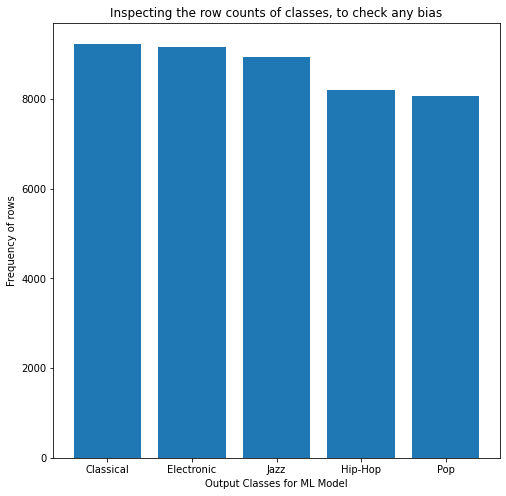

genre
Classical     9234
Electronic    9158
Hip-Hop       8200
Jazz          8934
Pop           8066
dtype: int64

In [ ]:
a = dataset.value_counts('genre')
x = a.index
y = a.values
fig,axs = plt.subplots(figsize=(8,8))
axs.bar(x,y)
axs.set_xlabel("Output Classes for ML Model")
axs.set_ylabel("Frequency of rows")
axs.set_title("Inspecting the row counts of classes, to check any bias")
plt.show()

display(dataset.groupby('genre').size())

To maintain the uniform distribution in dataset

In [ ]:
#resetting the index, to ease cleaning of excess rows
dataset.sort_values(by=['genre'],inplace=True)
dataset.reset_index(drop=True,inplace=True)


#creating an empty dataset with same structure as that of original dataset-frame
final_dataset = dataset[0:0]

#making a list of output classes/genres
c = dataset.genre.unique()

#populating the final_dataset with equal rows from each genre
for x in c:
  b = dataset.loc[dataset['genre'].isin([x])]
  final_dataset = final_dataset.append(b.iloc[0:5438],ignore_index=True)

#resetting the index of final_dataset
final_dataset.reset_index(drop=True,inplace=True)

Checking the final cleaned dataset distribution

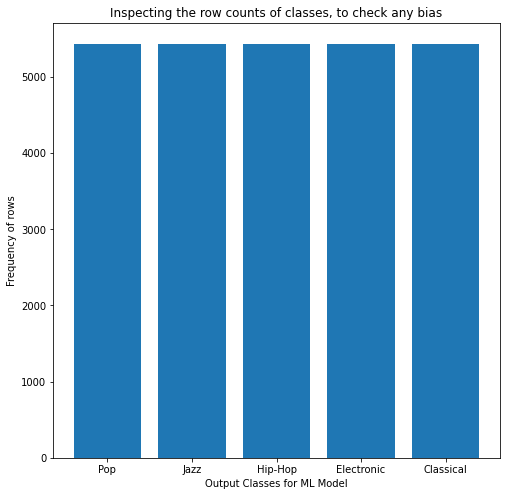

genre
Classical     5438
Electronic    5438
Hip-Hop       5438
Jazz          5438
Pop           5438
dtype: int64

In [ ]:
a = final_dataset.value_counts('genre')
x = a.index
y = a.values
fig,axs = plt.subplots(figsize=(8,8))
axs.bar(x,y)
axs.set_xlabel("Output Classes for ML Model")
axs.set_ylabel("Frequency of rows")
axs.set_title("Inspecting the row counts of classes, to check any bias")
plt.show()

display(final_dataset.groupby('genre').size())

# Customising the data to be fit for model

Label Encoding categorical variables like key, mode, time_signature and genre(output class)

In [ ]:
label_encoder = preprocessing.LabelEncoder()
final_dataset['key'] = label_encoder.fit_transform(final_dataset['key'])
print("Label Encoded Keys",final_dataset['key'].unique())

Label Encoded Keys [11  6  0  3  8  5  4  9 10  7  2  1]


In [ ]:
label_encoder = preprocessing.LabelEncoder()
final_dataset['mode'] = label_encoder.fit_transform(final_dataset['mode'])
print("Label Encoded Mode",final_dataset['mode'].unique())

Label Encoded Mode [0 1]


In [ ]:
label_encoder = preprocessing.LabelEncoder()
final_dataset['time_signature'] = label_encoder.fit_transform(final_dataset['time_signature'])
print("Label Encoded time_signature",final_dataset['time_signature'].unique())

Label Encoded time_signature [3 2 4 1 0]


In [ ]:
label_encoder = preprocessing.LabelEncoder()

#Adding additional column to preserve the mapping
final_dataset.insert(loc=0,column="genre_label",value=label_encoder.fit_transform(final_dataset['genre']))
print("Label Encoded genre_label",final_dataset['genre_label'].unique())

Label Encoded genre_label [0 1 2 3 4]


One Hot Encoding the categorical label-encoded varaibles

In [ ]:
final_dataset = pd.get_dummies(final_dataset, columns=['mode','key','time_signature'], prefix=['one_hot_mode','one_hot_key','one_hot_time'])
display(final_dataset)

,genre_label,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,one_hot_mode_0,one_hot_mode_1,one_hot_key_0,one_hot_key_1,one_hot_key_2,one_hot_key_3,one_hot_key_4,one_hot_key_5,one_hot_key_6,one_hot_key_7,one_hot_key_8,one_hot_key_9,one_hot_key_10,one_hot_key_11,one_hot_time_0,one_hot_time_1,one_hot_time_2,one_hot_time_3,one_hot_time_4
0,0,Classical,0,0.73800,0.486,180480,0.27600,0.742000,0.1510,-16.882,0.0553,83.663,0.2270,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0,Classical,43,0.98700,0.304,286667,0.15100,0.886000,0.1090,-23.326,0.0379,84.777,0.1330,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,0,Classical,43,0.95600,0.217,378253,0.12100,0.953000,0.0921,-21.123,0.0340,91.798,0.1020,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,Classical,43,0.68300,0.289,429600,0.32600,0.872000,0.1220,-14.722,0.0352,79.235,0.0723,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,Classical,43,0.99500,0.475,54520,0.00201,0.913000,0.0570,-32.196,0.1230,68.060,0.2810,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27185,4,Pop,62,0.02410,0.509,218787,0.91600,0.000402,0.3600,-2.793,0.0324,92.432,0.6720,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
27186,4,Pop,62,0.23200,0.742,285333,0.87300,0.000012,0.1140,-3.373,0.0820,90.004,0.8990,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
27187,4,Pop,62,0.56400,0.778,181244,0.43100,0.000000,0.1270,-6.454,0.0482,96.464,0.8430,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
27188,4,Pop,60,0.00312,0.402,198080,0.93100,0.000005,0.3370,-4.780,0.1670,180.000,0.6270,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


Correlation Map

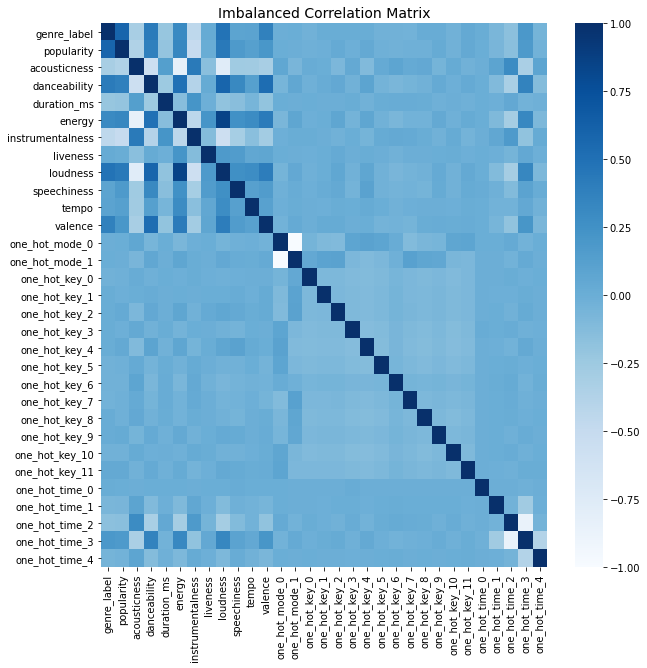

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))         
# Imbalanced DataFrame Correlation
corr = final_dataset.corr()
sns.heatmap(corr, cmap='Blues', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

# Final Dataset

In [ ]:
display(final_dataset.sample(10))

,genre_label,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,one_hot_mode_0,one_hot_mode_1,one_hot_key_0,one_hot_key_1,one_hot_key_2,one_hot_key_3,one_hot_key_4,one_hot_key_5,one_hot_key_6,one_hot_key_7,one_hot_key_8,one_hot_key_9,one_hot_key_10,one_hot_key_11,one_hot_time_0,one_hot_time_1,one_hot_time_2,one_hot_time_3,one_hot_time_4
3190,0,Classical,38,0.000031,0.1560,319987,0.9340,0.000023,0.3660,-4.530,0.0872,177.082,0.2030,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4873,0,Classical,35,0.850000,0.0701,325707,0.2370,0.823000,0.1750,-13.232,0.0355,74.886,0.0396,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
16779,3,Jazz,2,0.285000,0.7330,132500,0.4290,0.926000,0.0993,-7.956,0.1020,91.023,0.8550,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3008,0,Classical,35,0.991000,0.2220,110107,0.0777,0.813000,0.1440,-29.524,0.0422,93.841,0.2770,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
13567,2,Hip-Hop,50,0.025600,0.7180,211187,0.8250,0.000024,0.0825,-5.063,0.1280,150.103,0.5490,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
18548,3,Jazz,41,0.669000,0.5220,289560,0.5880,0.000012,0.3870,-8.928,0.0335,129.714,0.6540,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
21208,3,Jazz,35,0.343000,0.7630,278067,0.7530,0.514000,0.0512,-10.647,0.1140,118.722,0.8300,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
24192,4,Pop,87,0.010400,0.5880,238173,0.6700,0.000003,0.3380,-6.439,0.0473,118.159,0.5050,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
15497,2,Hip-Hop,61,0.607000,0.5440,210452,0.4460,0.000000,0.0923,-11.735,0.5360,115.192,0.4690,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
9590,1,Electronic,43,0.091300,0.6900,312040,0.8680,0.271000,0.1330,-8.944,0.0389,119.490,0.6570,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
display(final_dataset.describe())

,genre_label,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,one_hot_mode_0,one_hot_mode_1,one_hot_key_0,one_hot_key_1,one_hot_key_2,one_hot_key_3,one_hot_key_4,one_hot_key_5,one_hot_key_6,one_hot_key_7,one_hot_key_8,one_hot_key_9,one_hot_key_10,one_hot_key_11,one_hot_time_0,one_hot_time_1,one_hot_time_2,one_hot_time_3,one_hot_time_4
count,27190.00000,27190.000000,27190.000000,27190.000000,2.719000e+04,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000
mean,2.00000,48.484700,0.378609,0.570394,2.563293e+05,0.536845,0.272155,0.181095,-10.576620,0.103796,116.570179,0.414722,0.581537,0.418463,0.085289,0.076756,0.074108,0.109121,0.123428,0.091872,0.033431,0.068665,0.093821,0.066936,0.105406,0.071166,0.000037,0.010114,0.093159,0.876719,0.019971
std,1.41424,14.648725,0.374337,0.200637,1.279273e+05,0.281493,0.374313,0.150165,7.310039,0.108007,30.108780,0.253401,0.493316,0.493316,0.279316,0.266209,0.261952,0.311797,0.328934,0.288851,0.179764,0.252888,0.291585,0.249916,0.307082,0.257106,0.006065,0.100060,0.290661,0.328765,0.139902
min,0.00000,0.000000,0.000001,0.058200,1.969300e+04,0.000020,0.000000,0.014600,-47.432000,0.022500,34.765000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,37.000000,0.033300,0.437000,1.905950e+05,0.322000,0.000000,0.094500,-13.191500,0.039200,92.138250,0.198000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2.00000,46.000000,0.219000,0.601000,2.301070e+05,0.584000,0.002130,0.119000,-8.035000,0.052550,115.318000,0.392000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.00000,60.000000,0.776000,0.724000,2.876385e+05,0.763000,0.697000,0.213000,-5.580000,0.120000,137.896000,0.608000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,4.00000,99.000000,0.996000,0.987000,4.830606e+06,0.999000,0.994000,0.989000,1.585000,0.939000,239.848000,0.992000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
display(final_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27190 entries, 0 to 27189
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genre_label       27190 non-null  int64  
 1   genre             27190 non-null  object 
 2   popularity        27190 non-null  int64  
 3   acousticness      27190 non-null  float64
 4   danceability      27190 non-null  float64
 5   duration_ms       27190 non-null  int64  
 6   energy            27190 non-null  float64
 7   instrumentalness  27190 non-null  float64
 8   liveness          27190 non-null  float64
 9   loudness          27190 non-null  float64
 10  speechiness       27190 non-null  float64
 11  tempo             27190 non-null  float64
 12  valence           27190 non-null  float64
 13  one_hot_mode_0    27190 non-null  uint8  
 14  one_hot_mode_1    27190 non-null  uint8  
 15  one_hot_key_0     27190 non-null  uint8  
 16  one_hot_key_1     27190 non-null  uint8 

None

In [ ]:
display(final_dataset.shape)

(27190, 32)

Exporting final dataset to google drive

In [ ]:
final_dataset.to_csv('/content/drive/MyDrive/Colab Notebooks/music-genre-classification/MusicDataset.csv')

# Enhancing the dataset for model training

X will be the set of independent variables,

Y will be the dependent variable i.e Genre class (label encoded)

In [ ]:
X = final_dataset.iloc[:,2:]
display(X)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,one_hot_mode_0,one_hot_mode_1,one_hot_key_0,one_hot_key_1,one_hot_key_2,one_hot_key_3,one_hot_key_4,one_hot_key_5,one_hot_key_6,one_hot_key_7,one_hot_key_8,one_hot_key_9,one_hot_key_10,one_hot_key_11,one_hot_time_0,one_hot_time_1,one_hot_time_2,one_hot_time_3,one_hot_time_4
0,0,0.73800,0.486,180480,0.27600,0.742000,0.1510,-16.882,0.0553,83.663,0.2270,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,43,0.98700,0.304,286667,0.15100,0.886000,0.1090,-23.326,0.0379,84.777,0.1330,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,43,0.95600,0.217,378253,0.12100,0.953000,0.0921,-21.123,0.0340,91.798,0.1020,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,43,0.68300,0.289,429600,0.32600,0.872000,0.1220,-14.722,0.0352,79.235,0.0723,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,43,0.99500,0.475,54520,0.00201,0.913000,0.0570,-32.196,0.1230,68.060,0.2810,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27185,62,0.02410,0.509,218787,0.91600,0.000402,0.3600,-2.793,0.0324,92.432,0.6720,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
27186,62,0.23200,0.742,285333,0.87300,0.000012,0.1140,-3.373,0.0820,90.004,0.8990,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
27187,62,0.56400,0.778,181244,0.43100,0.000000,0.1270,-6.454,0.0482,96.464,0.8430,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
27188,60,0.00312,0.402,198080,0.93100,0.000005,0.3370,-4.780,0.1670,180.000,0.6270,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
Y = final_dataset.iloc[:,:1]
display(Y)

,genre_label
0,0
1,0
2,0
3,0
4,0
...,...
27185,4
27186,4
27187,4
27188,4


We need to normalise the columns like popularity, tempo, key, time_signature

# Decision Tree Algorithm

Epoch : 0	***************Accuracy Improved*******************************************
				 0.7440235380654653
Epoch : 1	***************Accuracy Improved*******************************************
				 0.7510114012504597
Epoch : 2	***************Accuracy Improved*******************************************
				 0.7568959176167709
Epoch :  3
Epoch :  4
Epoch : 5	***************Accuracy Improved*******************************************
				 0.759470393527032
Epoch :  6
Epoch :  7
Epoch :  8
Epoch :  9
Epoch :  10
Epoch :  11
Epoch :  12
Epoch :  13
Epoch :  14
Epoch :  15
Epoch :  16
Epoch :  17
Epoch :  18
Epoch :  19
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       531
           1       0.67      0.68      0.68       531
           2       0.79      0.74      0.76       559
           3       0.67      0.69      0.68       556
           4       0.75      0.80      0.77       542

    accuracy                           0.74      

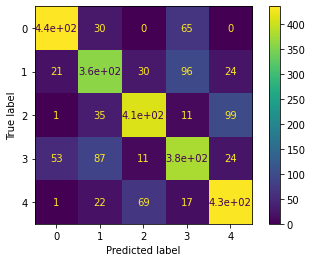

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
model = DecisionTreeClassifier()
epochs = 20
best_accuracy = 0

for i in range(epochs):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
  model.fit(X_train,y_train.values.ravel())

  y_pred = model.predict(X_test)
  current_accuracy = metrics.accuracy_score(y_test,y_pred)

  if current_accuracy > best_accuracy:
    print("Epoch : {}\t***************Accuracy Improved*******************************************".format(i))
    best_accuracy = current_accuracy
    print("\t\t\t\t",metrics.accuracy_score(y_test,y_pred))  
    with open("/content/drive/My Drive/Colab Notebooks/SpotifyPickels/decisionTree"+".pickle","wb") as f:
      pickle.dump(model,f)
  else:
    print("Epoch : ",i)


#Classification Report
print(classification_report(y_test,y_pred))

#confusion matrix
plot_confusion_matrix(model,X_test,y_test)

# Random Forest Algorithm

Epoch : 0	***************Accuracy Improved*******************************************
				 0.8267745494667157
Epoch : 1	***************Accuracy Improved*******************************************
				 0.8275101140125046
Epoch :  2
Epoch :  3
Epoch :  4
Epoch : 5	***************Accuracy Improved*******************************************
				 0.8278778962853991
Epoch :  6
Epoch :  7
Epoch :  8
Epoch :  9
Epoch :  10
Epoch :  11
Epoch :  12
Epoch :  13
Epoch :  14
Epoch : 15	***************Accuracy Improved*******************************************
				 0.8297168076498713
Epoch :  16
Epoch :  17
Epoch : 18	***************Accuracy Improved*******************************************
				 0.8344979771974991
Epoch :  19
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       571
           1       0.78      0.80      0.79       499
           2       0.84      0.76      0.80       592
           3       0.80      0.77      0.79       506
    

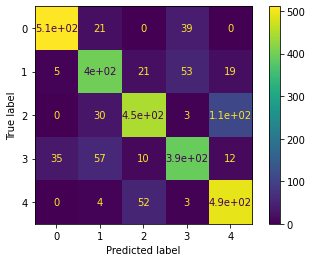

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)
epochs = 20
best_accuracy = 0

for i in range(epochs):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
  model.fit(X_train,y_train.values.ravel())

  y_pred = model.predict(X_test)
  current_accuracy = metrics.accuracy_score(y_test,y_pred)

  if current_accuracy > best_accuracy:
    print("Epoch : {}\t***************Accuracy Improved*******************************************".format(i))
    best_accuracy = current_accuracy
    print("\t\t\t\t",metrics.accuracy_score(y_test,y_pred))  
    with open("/content/drive/My Drive/Colab Notebooks/SpotifyPickels/rforest"+".pickle","wb") as f:
      pickle.dump(model,f)
  else:
    print("Epoch : ",i)


#Classification Report
print(classification_report(y_test,y_pred))

#confusion matrix
plot_confusion_matrix(model,X_test,y_test)

# Naive Bayes Algorithm


Epoch : 0	***************Accuracy Improved*******************************************
				 0.635895549834498
Epoch :  1
Epoch : 2	***************Accuracy Improved*******************************************
				 0.6439867598381758
Epoch : 3	***************Accuracy Improved*******************************************
				 0.6450901066568592
Epoch :  4
Epoch :  5
Epoch : 6	***************Accuracy Improved*******************************************
				 0.6454578889297535
Epoch : 7	***************Accuracy Improved*******************************************
				 0.6539168812063259
Epoch :  8
Epoch :  9
Epoch :  10
Epoch :  11
Epoch :  12
Epoch :  13
Epoch :  14
Epoch :  15
Epoch :  16
Epoch :  17
Epoch :  18
Epoch :  19
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       530
           1       0.57      0.60      0.59       558
           2       0.55      0.68      0.61       552
           3       0.57      0.44      0.50       531
     

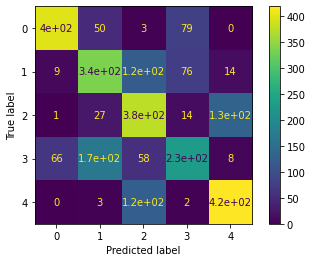

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
epochs = 20
best_accuracy = 0

for i in range(epochs):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
  model.fit(X_train,y_train.values.ravel())

  y_pred = model.predict(X_test)
  current_accuracy = metrics.accuracy_score(y_test,y_pred)

  if current_accuracy > best_accuracy:
    print("Epoch : {}\t***************Accuracy Improved*******************************************".format(i))
    best_accuracy = current_accuracy
    print("\t\t\t\t",metrics.accuracy_score(y_test,y_pred))  
    with open("/content/drive/My Drive/Colab Notebooks/SpotifyPickels/nbayes"+".pickle","wb") as f:
      pickle.dump(model,f)
  else:
    print("Epoch : ",i)
  
#Classification Report
print(classification_report(y_test,y_pred))

#confusion matrix
plot_confusion_matrix(model,X_test,y_test)

# SVM


Epoch : 0	***************Accuracy Improved*******************************************
				 0.31445384332475174
              precision    recall  f1-score   support

           0       0.46      0.38      0.41       530
           1       0.28      0.25      0.27       589
           2       0.26      0.07      0.11       519
           3       0.11      0.00      0.00       538
           4       0.29      0.86      0.44       543

    accuracy                           0.31      2719
   macro avg       0.28      0.31      0.25      2719
weighted avg       0.28      0.31      0.25      2719



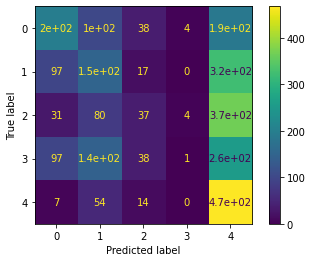

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

model = SVC(kernel="rbf")
epochs = 1
best_accuracy = 0

for i in range(epochs):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
  model.fit(X_train,y_train.values.ravel())

  y_pred = model.predict(X_test)
  current_accuracy = metrics.accuracy_score(y_test,y_pred)

  if current_accuracy > best_accuracy:
    print("Epoch : {}\t***************Accuracy Improved*******************************************".format(i))
    best_accuracy = current_accuracy
    print("\t\t\t\t",metrics.accuracy_score(y_test,y_pred))  
    with open("/content/drive/My Drive/Colab Notebooks/SpotifyPickels/svm"+".pickle","wb") as f:
      pickle.dump(model,f)
  else:
    print("Epoch : ",i)

#Classification Report
print(classification_report(y_test,y_pred))

#confusion matrix
plot_confusion_matrix(model,X_test,y_test)